# Can we make some kind of FDMT butterfly that makes sense?

In [9]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph
from collections import OrderedDict
%matplotlib inline
reload(fdmt)

<module 'fdmt' from '/Users/ban115/bolton/craft/code/python/fdmt.py'>

In [13]:
import importlib
bw = 0.016 # bandwidth GHz
Nd = 32 # number of DM trials
Nchan= 32
Nt = 16 # time block size
Tint = 0.864e-3 # integration time - seconds
f1 = 0.800
chanbw = 1e-3
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2
importlib.reload(fdmt)
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
print('INIT DELTA T', thefdmt.init_delta_t)

for i in range(thefdmt.niter):
    print('Iter', i, 'nchan', thefdmt.nchan_out_for_iter(i), thefdmt.ndm_out_for_iter(i), thefdmt.hist_state_shape[i],thefdmt.hist_state_shape[i+1])
    
print('TESTCONF')
testconf = ((0, 1, 2), (thefdmt.niter-1, 0, Nd-1))
for iterno, chan, idt in testconf:
    id1, id2, offset = thefdmt.get_config(iterno, chan, idt)
    print('iterno', iterno, 'idt', idt, 'chan', chan, 'id1', id1, 'id2', id2, 'offset', offset)
    (f_start, f_end, f_middle, f_middle_larger, delta_t_local, idt_data) = thefdmt.hist_nf_data[iterno][chan]
    print('Chaninfo', f_start, f_end, f_middle, f_middle_larger, delta_t_local)
    print('CFF check', f_middle, f_start, f_end, f_start, 'cff1', fdmt.cff(f_middle, f_start, f_end, f_start))



INIT DELTA T 3
Iter 0 nchan 16 4 [32  3 16] [16  4 20]
Iter 1 nchan 8 6 [16  4 20] [ 8  6 22]
Iter 2 nchan 4 10 [ 8  6 22] [ 4 10 26]
Iter 3 nchan 2 18 [ 4 10 26] [ 2 18 34]
Iter 4 nchan 1 32 [ 2 18 34] [ 1 32 48]
TESTCONF
iterno 0 idt 2 chan 1 id1 1 id2 0 offset 2
Chaninfo 0.802 0.804 0.8025 0.8035 4
CFF check 0.8025 0.802 0.804 0.802 cff1 0.25070107979
iterno 4 idt 31 chan 0 id1 15 id2 15 offset 16
Chaninfo 0.8 0.832 0.8155 0.8165 32
CFF check 0.8155 0.8 0.832 0.8 cff1 0.499076648103


# OK so what if we did something like "Minimise the number of connections"
Basically we load computing into nodes until we need more connectivity than we want (let's say 2 connections) and then make another node.

In [14]:


class FdmtUnit(object):
    def __init__(self, net, unitid, iterno, ichan, dms=None):
        self.net = net
        self.unitid = unitid
        self.iterno = iterno
        self.ichan = ichan
        self.reads = []
        if dms is None:
            dms = []
            
        self.dms = sorted(list(dms))
        self.computes = {}
        
    @property
    def ochan(self):
        o = (self.ichan) // 2 # Assumes power of 2 FDMT
        return o
    
    def owns(self, iterno, ichan, dm):
        return iterno == self.iterno and ichan == self.ichan and dm in self.dms
    
    def add_odt(self, dt, n1, n2, id1, id2, offset):
        if dt not in self.dms:
            self.dms.append(dt)  
            
        self.computes[dt] = (dt, n1, n2, id1, id2, offset)
        
    def add_read(self, idt, offset, unit, odt):
        assert idt in self.dms
        self.reads.append((idt, offset, unit, odt))
        
    def get_max_offset(self, dt=None):
        assert dt in self.dms
        if dt is None:
            reads = self.reads
        else:
            reads = list(filter(lambda r: r[0] == dt))
            
        maxoff = max(reads, key=lambda r:r[1])[1]
        
        return maxoff
    
    @property
    def inputs(self):
        return self.net.inputs.get(self, [])
    
    @property
    def outputs(self):
        return self.net.outputs.get(self, [])
        
    @property
    def ndms(self):
        return len(self.dms)
    
    def digraph(self, format='pdf'):
        maindot = Digraph(comment='FDMT', format=format)
        
        for u in self.inputs:
            maindot.edge(str(u), str(self))
            
        for u in self.outputs:
            maindot.edge(str(self), str(u))                    
            
        return maindot
    
    def __str__(self):
        iterno = self.iterno
        ichan = self.ichan
        dm0 = min(self.dms)
        dmn = max(self.dms)
        unitid = self.unitid
        s = 'I{iterno}U{unitid}C{ichan}D{dm0}-{dmn}'.format(**locals())
        
        return s
    
    __repr__ = __str__
    
class FdmtNet(object):
    def __init__(self, thefdmt):
        self.thfdmt = thefdmt
        self.units = []
        self.links = []
        
    def add_unit(self, iterno, ichan, dms=None):
        unitid = len(self.find_unit_iter(iterno))
        unit = FdmtUnit(self, unitid, iterno, ichan, dms)
        self.units.append(unit)
        return unit
    
    def find_unit(self, iterno, ichan, dm):
        units = [u for u in self.units if u.owns(iterno, ichan, dm)]
        
        if len(units) == 0:
            raise ValueError('Could not find unit that owns I={} chan={} idm={}'.format(iterno, ichan, dm))
        
        if len(units) >= 2:
            raise ValueError('>1 unit services I={} chan={} idm={} ={}'.format(iterno, ichan, dm, list(map(str, units))))
            
        return units[0]
    
    def find_unit_iter(self, iterno):
        return [u for u in self.units if u.iterno == iterno]
    
    
    def add_link(self, unit1, unit2, id1, offset, odt):
        assert unit1.iterno + 1 == unit2.iterno
        assert unit1 in self.units
        assert unit2 in self.units
        if (unit1, unit2) not in self.links:
            self.links.append((unit1, unit2))
        
        unit1.add_read(id1, offset, unit2, odt)
            
    def clean(self):
        '''
        Delete units and links that have no output
        '''
        maxiter = max(self.units, key=lambda u: u.iterno).iterno
        non_last_units = [u for u in self.units if u.iterno < maxiter]
        removed = []
        for u in non_last_units:
            if u not in self.outputs:
                self.units.remove(u)
                assert u not in self.units
                self.remove_links_to_unit(u)
                assert u not in list(self.outputs.keys())
                removed.append(u)
                
        return removed
                
    def remove_links_to_unit(self, unit):
        # filter links with destination = 
        links = []
        #print('Removing link to unit', str(unit))
        for l in self.links:
            if l[0] == unit or l[1] == unit:
                #print 'Found match', str(l[0]), str(l[1]), unit
                pass
            else:
                links.append(l)
        #self.links = filter(lambda l: not (l[0] == unit or l[1] == unit), self.links)
        self.links = links
    
    @property
    def nlinks(self):
        return len(self.links)
    
    @property
    def nunits(self):
        return len(self.units)
    
    
    def digraph(self, format='pdf', iters=None):
        maindot = Digraph(comment='FDMT', format='pdf')
        if iters is None:
            units = self.units
        else:
            units = [u for u in self.units if u.iterno in iters]
            
        for u in units:
            maindot.node(str(u))
            
        for u1, u2 in self.links:
            assert u1 in self.units
            assert u2 in self.units
            if u1 in units and u2 in units:
                maindot.edge(str(u1), str(u2))
            
        return maindot
    
    @property
    def inputs(self):
        conn = {}
        for n1, n2 in self.links:
            l = conn.get(n2, [])
            l.append(n1)
            conn[n2] = l
            
        return conn
    
    @property
    def outputs(self):
        conn = {}
        for n1, n2 in self.links:
            l = conn.get(n1, [])
            l.append(n2)
            conn[n1] = l
            
        return conn
    
        
links = {}
nnodes = 0
nplotnodes = 0
max_nd_per_unit = 12
net = FdmtNet(thefdmt)

max_nd_for_iter = {0:8, 1:8}
max_nd_for_iter = {}
        
for c in range(thefdmt.nchan_in_for_iter(0)):
    ndmin = thefdmt.ndm_in_for_iter(0)
    idms = np.arange(ndmin)
    unit = net.add_unit(0, c, idms)
        
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    in_shape = thefdmt.hist_state_shape[iterno]
    out_shape = thefdmt.hist_state_shape[iterno+1]
    nchan, ndt, nt_out = out_shape
    print('Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod()))
    for ochan in range(nchan):
        chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
        inchan1 = 2*ochan
        inchan2 = inchan1+1
        
        in1 = None
        in2 = None
        thisunit = None
        inputs = set()
                        
        for odt, config in enumerate(chanconfig):
            _, id1, offset, id2, _, _, _ = config
            do_copy = id2 == -1
            n1 = net.find_unit(iterno, inchan1, id1)
            n2 = net.find_unit(iterno, inchan2, id2)
            
            # Make a new output node if the input node changes (or if we've exceeded NDM for this node)
            nd = 0 if thisunit is None else thisunit.ndms
            
            # Add inputs to set - it just counts how many unique inputs we *would* have
            inputs.add(n1)
            inputs.add(n2)
                
            ndmax = max_nd_for_iter.get(iterno, max_nd_per_unit)

            if nd == ndmax or thisunit is None:
                thisunit = net.add_unit(iterno+1, ochan)
                inputs = set([n1, n2])
                
            net.add_link(n1, thisunit, id1, 0, odt)
            net.add_link(n2, thisunit, id2, offset, odt)
            thisunit.add_odt(odt, n1, n2, id1, id2, offset)
            in1 = n1
            in2 = n2

def deep_clean(net):
    dremoved = []
    while True:
        removed = net.clean()
        dremoved.extend(removed)
        if len(removed) == 0:
            break
        else:
            print(('Removed', len(removed)))
    return dremoved
            
removed = deep_clean(net)
            
print(('Done got {net.nunits} units and {net.nlinks} links. Removed {removed} dead nodes'.format(net=net, removed=len(removed))))

Iteration 0 in=[32  3 16]=96 out=[16  4 20]=64
Iteration 1 in=[16  4 20]=64 out=[ 8  6 22]=48
Iteration 2 in=[ 8  6 22]=48 out=[ 4 10 26]=40
Iteration 3 in=[ 4 10 26]=40 out=[ 2 18 34]=36
Iteration 4 in=[ 2 18 34]=36 out=[ 1 32 48]=32
Done got 67 units and 71 links. Removed 0 dead nodes


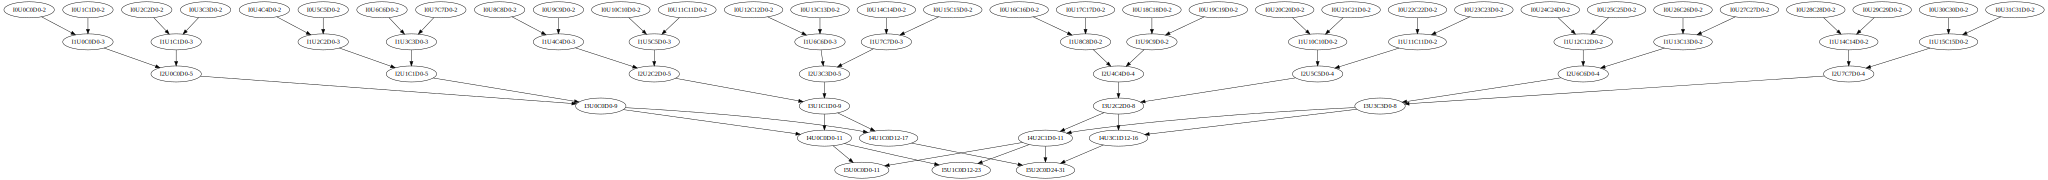

In [15]:
net.digraph()

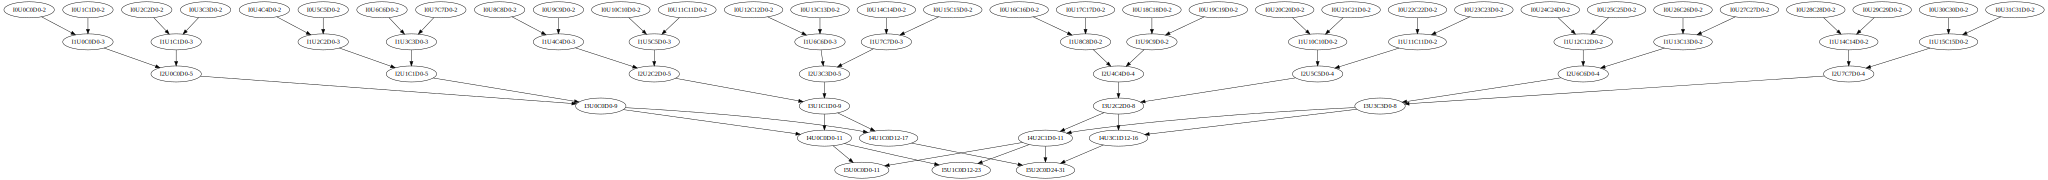

In [16]:
#net.clean()
net.digraph()

In [17]:
ninputs = [len(inputs) for unit, inputs in net.inputs.items()]
noutputs = [len(outputs) for unit, outputs in net.outputs.items()]
ndms = [u.ndms for u in net.units]
print((np.unique(ninputs)))
print((np.unique(noutputs)))
print((np.unique(ndms)))

[2 3]
[1 2 3]
[ 3  4  5  6  8  9 10 12]


In [18]:
for unit, outputs in net.outputs.items():
    print(unit, list(map(str, outputs)))

I0U23C23D0-2 ['I1U11C11D0-2']
I2U3C3D0-5 ['I3U1C1D0-9']
I0U15C15D0-2 ['I1U7C7D0-3']
I0U26C26D0-2 ['I1U13C13D0-2']
I0U22C22D0-2 ['I1U11C11D0-2']
I0U18C18D0-2 ['I1U9C9D0-2']
I0U12C12D0-2 ['I1U6C6D0-3']
I0U25C25D0-2 ['I1U12C12D0-2']
I0U17C17D0-2 ['I1U8C8D0-2']
I1U4C4D0-3 ['I2U2C2D0-5']
I0U19C19D0-2 ['I1U9C9D0-2']
I1U6C6D0-3 ['I2U3C3D0-5']
I0U20C20D0-2 ['I1U10C10D0-2']
I4U0C0D0-11 ['I5U0C0D0-11', 'I5U1C0D12-23']
I2U0C0D0-5 ['I3U0C0D0-9']
I0U13C13D0-2 ['I1U6C6D0-3']
I1U8C8D0-2 ['I2U4C4D0-4']
I0U16C16D0-2 ['I1U8C8D0-2']
I0U7C7D0-2 ['I1U3C3D0-3']
I4U1C0D12-17 ['I5U2C0D24-31']
I2U4C4D0-4 ['I3U2C2D0-8']
I0U9C9D0-2 ['I1U4C4D0-3']
I1U15C15D0-2 ['I2U7C7D0-4']
I0U4C4D0-2 ['I1U2C2D0-3']
I1U7C7D0-3 ['I2U3C3D0-5']
I0U21C21D0-2 ['I1U10C10D0-2']
I3U1C1D0-9 ['I4U0C0D0-11', 'I4U1C0D12-17']
I0U30C30D0-2 ['I1U15C15D0-2']
I1U13C13D0-2 ['I2U6C6D0-4']
I0U14C14D0-2 ['I1U7C7D0-3']
I4U2C1D0-11 ['I5U0C0D0-11', 'I5U1C0D12-23', 'I5U2C0D24-31']
I0U10C10D0-2 ['I1U5C5D0-3']
I3U0C0D0-9 ['I4U0C0D0-11', 'I4U1C0D12-17']
I1

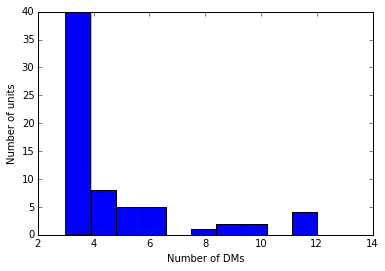

In [19]:
bins = (np.arange(max_nd_per_unit+2)-0.5)
hist(ndms)
xlabel('Number of DMs')
ylabel('Number of units')

(array([34.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <a list of 10 Patch objects>)

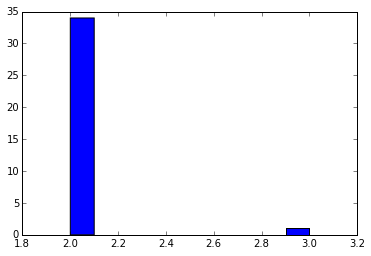

In [20]:
hist(ninputs)

(array([58.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

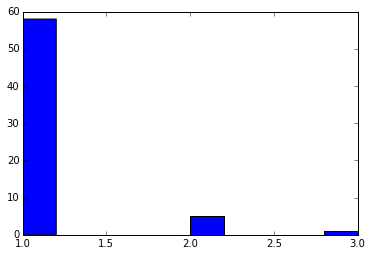

In [21]:
hist(noutputs)

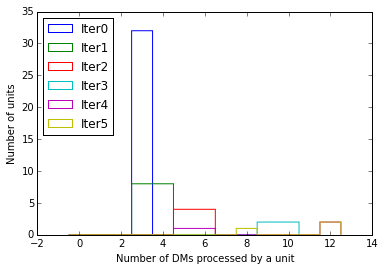

In [22]:
for iterno in range(0, thefdmt.niter+1):
    ndms = [u.ndms for u in net.units if u.iterno == iterno]
    
    if len(ndms) > 0:
        hist(ndms, bins=(np.arange(max(ndms)+2) - 0.5), histtype='step', label='Iter{}'.format(iterno))
    
legend(loc='upper left')
xlabel('Number of DMs processed by a unit')
ylabel('Number of units')

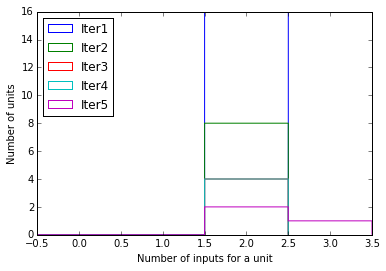

In [23]:
for iterno in range(0, thefdmt.niter+1):
    ninputs = [len(inputs) for unit, inputs in net.inputs.items() if unit.iterno == iterno]
    if len(ninputs) > 0:
        hist(ninputs, bins=(np.arange(max(ninputs)+2) - 0.5), histtype='step', label='Iter{}'.format(iterno))
    
legend(loc='upper left')
xlabel('Number of inputs for a unit')
ylabel('Number of units')

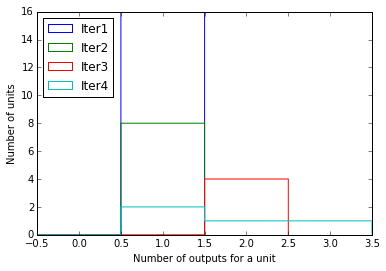

In [24]:
for iterno in range(1, thefdmt.niter+1):
    outputs = [len(outputs) for unit, outputs in net.outputs.items() if unit.iterno == iterno]
    if len(outputs) > 0:
        hist(outputs, bins=(np.arange(max(outputs)+2) - 0.5), histtype='step', label='Iter{}'.format(iterno))
    
legend(loc='upper left')
xlabel('Number of outputs for a unit')
ylabel('Number of units')

In [25]:
big_output_units = [unit for unit, outputs in net.outputs.items() if len(outputs) == 4]

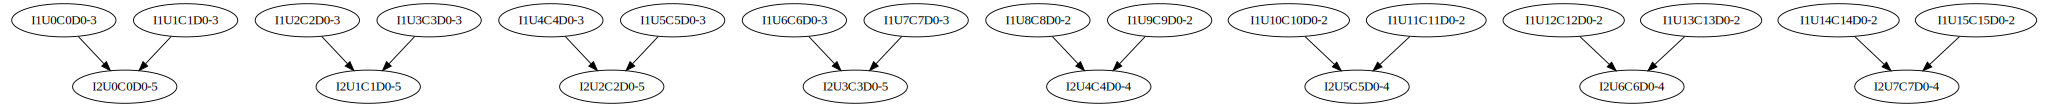

In [26]:
net.digraph(iters=(1,2))

In [27]:
u = big_output_units[0]
print(u)
print((u.outputs))
print((u.inputs))
u.digraph()

IndexError: list index out of range

In [ ]:
for r in u.reads:
    print(r)

In [ ]:
u2 = net.find_unit(8,0,192)
u2.digraph()

In [ ]:
u3 = net.find_unit(8,0,208)
u3.digraph()

In [ ]:
processing_iterations = np.arange(thefdmt.niter) + 1
nunits = [len(net.find_unit_iter(iterno)) for iterno in processing_iterations]
plot(processing_iterations, nunits)
xlabel('Iteration')
ylabel('Number of units')
print((nunits, sum(nunits) ))



# OK, so let's drive the iterations from NUNITS

For an iteration, choose a size of `ND[ITER] = min(NDMAX, nd_in_for_iter(iter))` for that iteration. Each unit in an iteration processes `ND[ITER]`

Each unit processes 2 (and only 2) input channels, and up to `ND[ITER]` DMs
Units process `ND[iter]` DMS from the DM space in increaing blocks, i.e. `0..ND[ITER]` for the first unit, `ND[iter]..2ND[iter]-1` fo rthe second unit, etc, etc.

In a unit: Each DM is computed sequentially with II=1
It takes up to `ND[iter]` clocks to compute all of a unit's DMs (up to NDMAX clocks)
Each unit collects data from 4 units from the previous iteration, and writes to 4 units in the next iteration.
The number of output units can be anywhere between 1-4. In one extreme, all DMS go to 1 output unit. In the other extreme, the DMS spread evenly between 4 outputs. To cover all extremes you'd need a `4xND[iter]` array for the output of a unit.
Unclear whether you'd reshape cyclic or have a separate dimension.

FIFO memory for each unit is tricky. One idea: Pair up the lowest and highest DMs so you always have (approximately) a square. Nice, but you end up having more inputs and outputs. 

At the least: each unit needs its own FIFO bank which might be differently sized for each unit. There roughtly 621 units. that's how many read/write ports we need. Ideally each unit could have a dynamically chosen size of FIFO bank. For small ones, LUT-based shift register, for others BRAM.

OK continuing with that highest-and-lowest-DMs idea: You can pair the high-and-low DM units together to share a FIFO bank so thay everything squares off. I.e. the sum of highest and lowest DMs shoudl be always roughly eequal. The size of the FIFO bank for an iteration is `[NUNIT[iter]/2][ND[ITER] * FIFO_SIZE[iter]]` where `NUNIT[iter]` is the number of units in an iteration `FIFO_SIZE[iter] = MAX_OFFSET[iter][0] + MAX_OFFSET[iter][maxdm-1]` and `MAX_OFFSET[iter][dm]` is the largest read offset for a given DM and fifo. This array is paritioned COMPLETE on dim=1 and `CYCLIC factor=FIFO_SIZE[iter]/2` on dim=2 so that `NUNIT[iter]` units can each access it at `II=1`.

Two units that share the same bank process DMs in opposing order. I.e. The even numbered iterate from 0..ND[ITER]-1 and the odd number iterate from ND[iter]-1..0. This means the two units never read from the same port at the same time. That's convivial of them, itsn't it?

With  C++ templating we should be able to make these types easy to declare, and (in a `dataflow`?) assign them to different resources. e.g. BRAM for some and URAM for the larger ones, so that we can minimise the total resources used. We might even be able to PIPO them so that the history load can be done in parallel. Oooooooh.

Maybe the details of the array dimensioning and partitioning aren't exactly right. Basically we need `NUNIT[iter]` ports and `NUNIT[iter] x ND[iter] x FIFO_SIZE[iter]` entries, but we stack them all together. Don't know if 2 dimensions or 3 is better. 

Gosh I like the idea of URAM and PIPO'ing. For iteration 1, this is 128 ports and 128x12x32 =  128 BRAM for ports and only 43 BRAM for entries, i.e. 128 BRAM which are partially full. For the final iteration it's 64 ports and 64x16x650 = 591 BRAM for entries (which is a lot). *BUT* if we used URAM we'd only need 37 URAM for entries (piece of CAKE!). In practice you'd need 1 URAM per port (i.e. 1 URAM for each UNIT) but that's only 64 URAM! Maybe you need dual port, so you need to cyclic=2 for the URAM, but still that's only 128, and to double buffer it's 256, and there's 320 on an SLR. Yoiks, that's still rather a lot. But still, maybe you only use them for the last iteration.


Iteration 0 in=[32  3 16]=96 out=[16  4 20]=64
Iteration 1 in=[16  4 20]=64 out=[ 8  6 22]=48
Iteration 2 in=[ 8  6 22]=48 out=[ 4 10 26]=40
Iteration 3 in=[ 4 10 26]=40 out=[ 2 18 34]=36
Iteration 4 in=[ 2 18 34]=36 out=[ 1 32 48]=32
Got 66 Units total


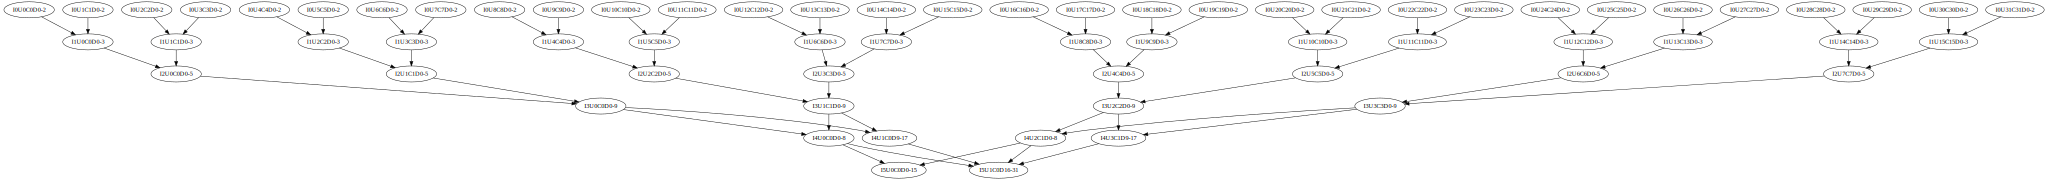

In [28]:
# OK LET'S TRY THIS - DO IT REAAAALL EASY LIKE

MAX_NUNIT = 128

MAX_DM_PER_UNIT = 16
net = FdmtNet(thefdmt)

class IterConfig(object):
    def __init__(self, thefdmt, iterno):
        ndm = thefdmt.ndm_out_for_iter(iterno)
        nchan = thefdmt.nchan_out_for_iter(iterno)
        nunit_per_chan = (ndm + MAX_DM_PER_UNIT - 1) // MAX_DM_PER_UNIT
        ndm_per_unit = (ndm + nunit_per_chan - 1) // nunit_per_chan
        assert ndm_per_unit*nunit_per_chan >= ndm
        total_nunit = nchan * nunit_per_chan
        self.ndm = ndm
        self.nchan = nchan
        self.nunit_per_chan = nunit_per_chan
        self.ndm_per_unit = ndm_per_unit
        self.total_nunit = total_nunit
        self.thefdmt = thefdmt
        self.iterno = iterno
        
        
    def get_cff(self, ochan):
        iterno = self.iterno
        thefdmt = self.thefdmt
        correction = thefdmt.d_f/2.0
        fres = thefdmt.d_f * (2**(iterno + 1))
        f_start = fres * float(ochan) + thefdmt.f_min
        f_end = f_start + fres
        f_middle = f_start + fres/2.0 - correction
        f_middle_larger = f_middle + 2*correction
        cff1 = fdmt.cff(f_middle, f_start, f_end, f_start)
        cff2 = fdmt.cff(f_middle_larger, f_start, f_end, f_start)
        
        return (cff1, cff2)
        
    def get_config(self, ochan, odm):
        '''
        Calculate the DM config given the iteration number, output channel and output dm
        '''
        cff1, cff2 = self.get_cff(ochan)
        id1 = int(round(odm * cff1))
        offset = int(round(odm * cff2))
        id2 = odm - offset
        
        return (id1, id2, offset)
        
        
    def __str__(self):
        s = 'Iteration {iterno} nchan={nchan} ndm={ndm} ndm_per_unit={ndm_per_unit} nunit_per_chan={nunit_per_chan} nunits={total_nunit}'.format(**vars(self))
        return s
    
    __repr__ = __str__


# Input data
for c in range(thefdmt.nchan_in_for_iter(0)):
    ndmin = thefdmt.ndm_in_for_iter(0)
    idms = np.arange(ndmin)
    unit = net.add_unit(0, c, idms)

# processing nodes

for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    conf = IterConfig(thefdmt, iterno)
    for c in range(conf.nchan):
        for u in range(conf.nunit_per_chan):
            idms = np.arange(u*conf.ndm_per_unit, min((u+1)*conf.ndm_per_unit, conf.ndm))
            #print c, u, idms, u, nunit_per_chan, (u+1)*nunit_per_chan
            unit = net.add_unit(iterno+1, c, idms)
            #print unit
            
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    in_shape = thefdmt.hist_state_shape[iterno]
    out_shape = thefdmt.hist_state_shape[iterno+1]
    nchan, ndt, nt_out = out_shape
    print('Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod()))
    for ochan in range(nchan):
        chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
        inchan1 = 2*ochan
        inchan2 = inchan1+1
                        
        for odt, config in enumerate(chanconfig):
            _, id1, offset, id2, _, _, _ = config
            do_copy = id2 == -1
            n1 = net.find_unit(iterno, inchan1, id1)
            n2 = net.find_unit(iterno, inchan2, id2)
            thisunit = net.find_unit(iterno+1, ochan, odt)                           
            net.add_link(n1, thisunit, id1, 0, odt)
            net.add_link(n2, thisunit, id2, offset, odt)
            thisunit.add_odt(odt, n1, n2, id1, id2, offset)
print("Got", len(net.units), 'Units total')
            
net.digraph()


In [29]:
net.digraph(iters=[7,8])

In [30]:
ninputs = [len(inputs) for unit, inputs in net.inputs.items()]
noutputs = [len(outputs) for unit, outputs in net.outputs.items()]
ndms = [u.ndms for u in net.units]
print((np.unique(ninputs)))
print((np.unique(noutputs)))
print((np.unique(ndms)))

[2 4]
[1 2]
[ 3  4  6  9 10 16]


(array([58.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

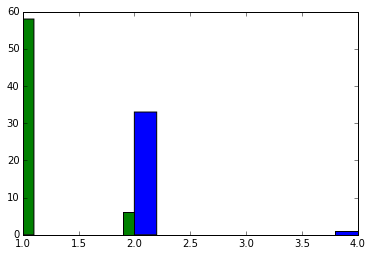

In [31]:
hist(ninputs)
hist(noutputs)

In [32]:
# Mkay, let's try to execute something
def print_reads():
    MAX_NOUT = 4
    nreads = []
    ncomputes = []
    num_non_sequential = 0
    num_sequential_reads = 0
    num_duplicate_reads = 0
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        in_shape = thefdmt.hist_state_shape[iterno]
        out_shape = thefdmt.hist_state_shape[iterno+1]
        nchan, ndt, nt_out = out_shape
        print('Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod()))
        for unit in net.find_unit_iter(iterno+1):
            print(unit, ' has', len(unit.computes), ' computes and ', len(unit.reads), 'reads')
            assert len(unit.computes) <= MAX_DM_PER_UNIT
            assert len(unit.reads) <= MAX_DM_PER_UNIT*MAX_NOUT
            nreads.append(len(unit.reads))
            ncomputes.append(len(unit.computes))
            if len(unit.reads) == 0:
                print("***** ZERO READS FOR", unit)

            currdm = None
            curroffset = 0
            for read in unit.reads:
                print('\t', 'read to', read)
                idm, ioffset, tounit, todm = read
                if idm != currdm:
                    currdm = idm
                    curroffset = ioffset 
                else:
                    if ioffset == curroffset:
                        num_duplicate_reads += 1
                    elif ioffset == curroffset + 1:
                        num_sequential_reads += 1
                    else:
                        print('Non sqeuential read!', read)
                        num_non_sequential += 1
                        
                    curroffset = ioffset
                    
                
    print('Number of sequential reads', num_sequential_reads)
    print('Number of duplicate reads', num_duplicate_reads)
    print('Number of non sequential reads', num_non_sequential)

    
    return nreads, ncomputes


nreads, ncomputes = print_reads()
                
    

Iteration 0 in=[32  3 16]=96 out=[16  4 20]=64
I1U0C0D0-3  has 4  computes and  6 reads
	read to (0, 0, I2U0C0D0-5, 0)
	read to (0, 0, I2U0C0D0-5, 1)
	read to (1, 0, I2U0C0D0-5, 2)
	read to (1, 0, I2U0C0D0-5, 3)
	read to (2, 0, I2U0C0D0-5, 4)
	read to (2, 0, I2U0C0D0-5, 5)
I1U1C1D0-3  has 4  computes and  6 reads
	read to (0, 0, I2U0C0D0-5, 0)
	read to (0, 1, I2U0C0D0-5, 1)
	read to (1, 1, I2U0C0D0-5, 2)
	read to (1, 2, I2U0C0D0-5, 3)
	read to (1, 3, I2U0C0D0-5, 4)
	read to (2, 3, I2U0C0D0-5, 5)
I1U2C2D0-3  has 4  computes and  6 reads
	read to (0, 0, I2U1C1D0-5, 0)
	read to (0, 0, I2U1C1D0-5, 1)
	read to (1, 0, I2U1C1D0-5, 2)
	read to (1, 0, I2U1C1D0-5, 3)
	read to (2, 0, I2U1C1D0-5, 4)
	read to (2, 0, I2U1C1D0-5, 5)
I1U3C3D0-3  has 4  computes and  6 reads
	read to (0, 0, I2U1C1D0-5, 0)
	read to (0, 1, I2U1C1D0-5, 1)
	read to (1, 1, I2U1C1D0-5, 2)
	read to (1, 2, I2U1C1D0-5, 3)
	read to (1, 3, I2U1C1D0-5, 4)
	read to (2, 3, I2U1C1D0-5, 5)
I1U4C4D0-3  has 4  computes and  6 reads
	rea

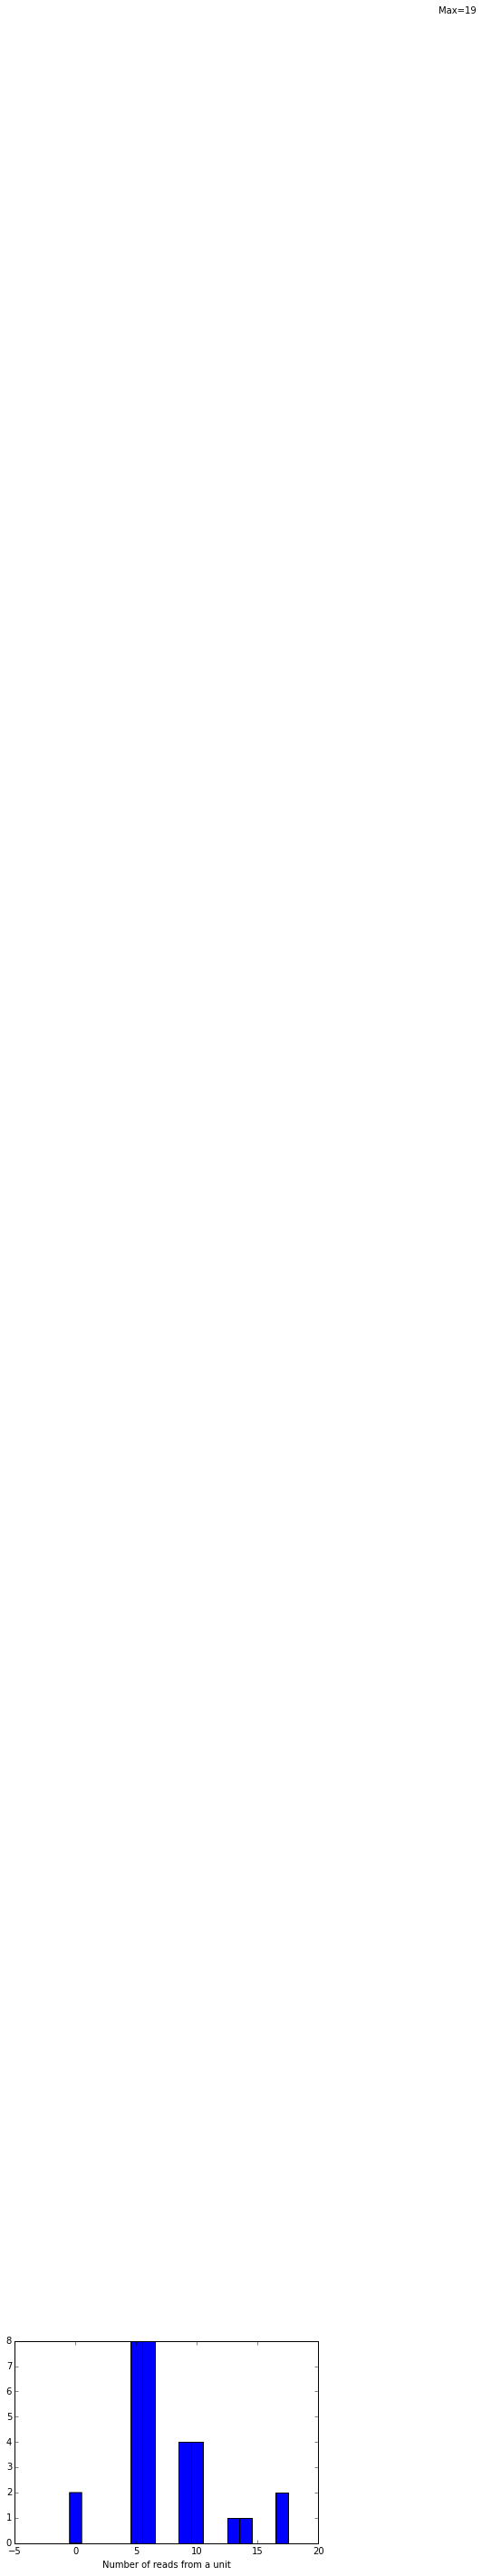

In [33]:
hist(nreads, bins=np.arange(max(nreads))-0.5)
xlabel('Number of reads from a unit')
text(30, 100, 'Max={}'.format(max(nreads)))

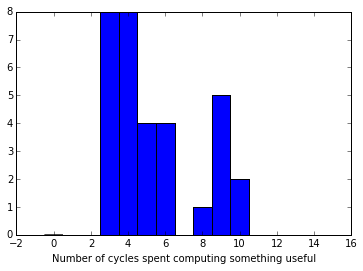

In [34]:
hist(ncomputes, bins=np.arange(max(ncomputes))-0.5)
xlabel('Number of cycles spent computing something useful')

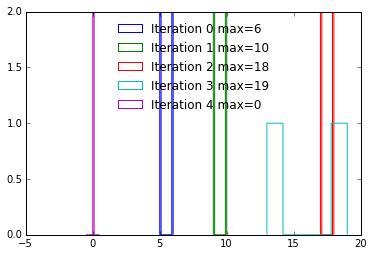

In [35]:
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    nreaditer = [len(unit.reads) for unit in net.find_unit_iter(iterno+1)]
    hist(nreaditer, label='Iteration {} max={}'.format(iterno, max(nreaditer)), histtype='step')
    
legend(frameon=False, loc='upper center')


40 [16, 8, 8, 6, 2]


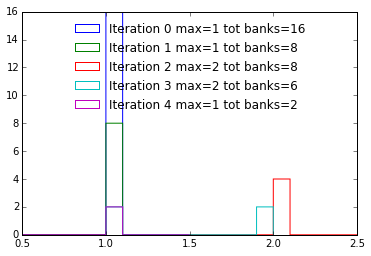

In [36]:
all_banks = []

for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    nbanks = [(len(unit.reads) + MAX_DM_PER_UNIT) // MAX_DM_PER_UNIT for unit in net.find_unit_iter(iterno+1)]
    tot_banks = sum(nbanks)
    hist(nbanks, label='Iteration {} max={} tot banks={}'.format(iterno, max(nbanks), tot_banks), histtype='step')
    all_banks.append(tot_banks)
    
legend(frameon=False, loc='upper center')
print(sum(all_banks), all_banks)


In [37]:
MAX_NOUT = 3 # Maximum numbef of outputs we need to send in a clock cycle per unit

class FdmtState(object):
    def __init__(self, net):
        self.net = net
        
        
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    in_shape = thefdmt.hist_state_shape[iterno]
    out_shape = thefdmt.hist_state_shape[iterno+1]
    nchan, ndt, nt_out = out_shape
    print('Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod()))
    conf = IterConfig(thefdmt, iterno)
    #output_conf = IterConfig(thefdmt, iterno+1)
    this_units = net.find_unit_iter(iterno+1) # this is the configuration for the output
    print('this conf', conf)
    assert len(this_units) == conf.total_nunit

    for iunit, unit in enumerate(this_units):
        #print unit, ' has', len(unit.computes), ' computes and ', len(unit.reads), 'reads'
        assert len(unit.computes) <= MAX_DM_PER_UNIT
        assert len(unit.reads) <= MAX_DM_PER_UNIT*MAX_NOUT
        # Let's see if I can work out what I need to do
        
        ochan = iunit // conf.nunit_per_chan # output channel
        odmidx = iunit % conf.nunit_per_chan # which DM slice I'm looking after

        ichan1 = ochan * 2
        ichan2 = ochan * 2 + 1
        for dmidx in range(conf.ndm_per_unit):
            odm = odmidx*conf.ndm_per_unit + dmidx
            # WE're going to compute more than we need especially for the higher
            # channels but I think that's OK.
            # For each DM we're going to compute 1 thing and put it onto a FIFO
            # and read MAX_NOUT thing from the FIFos and put them into the states
            (id1, id2, offset) = conf.get_config(ochan, odm)
            print(iterno, iunit, unit, ochan, odmidx, odm, ichan1, ichan2 ,id1, id2, offset, len(unit.reads), len(unit.computes))
            #in1 = state.get(iterno, iunit, ochan, odm, ichan1, id1, 0)
            #in2 = state.get(iterno, iunit, ochan, odm, ichan2, id2, offset)
            #fifos.shift(iterno, iunit, ochan, odm, in1 + in2)
            
            #for iout in xrange(MAX_NOUT):
            #    state.put(iterno, iunit, ochan, odm, iout, fifos.read(iterno, iunit, ochan, odm, iout))
            

Iteration 0 in=[32  3 16]=96 out=[16  4 20]=64
this conf Iteration 0 nchan=16 ndm=4 ndm_per_unit=4 nunit_per_chan=1 nunits=16
0 0 I1U0C0D0-3 0 0 0 0 1 0 0 0 6 4
0 0 I1U0C0D0-3 0 0 1 0 1 0 0 1 6 4
0 0 I1U0C0D0-3 0 0 2 0 1 1 0 2 6 4
0 0 I1U0C0D0-3 0 0 3 0 1 1 1 2 6 4
0 1 I1U1C1D0-3 1 0 0 2 3 0 0 0 6 4
0 1 I1U1C1D0-3 1 0 1 2 3 0 0 1 6 4
0 1 I1U1C1D0-3 1 0 2 2 3 1 0 2 6 4
0 1 I1U1C1D0-3 1 0 3 2 3 1 1 2 6 4
0 2 I1U2C2D0-3 2 0 0 4 5 0 0 0 6 4
0 2 I1U2C2D0-3 2 0 1 4 5 0 0 1 6 4
0 2 I1U2C2D0-3 2 0 2 4 5 1 0 2 6 4
0 2 I1U2C2D0-3 2 0 3 4 5 1 1 2 6 4
0 3 I1U3C3D0-3 3 0 0 6 7 0 0 0 6 4
0 3 I1U3C3D0-3 3 0 1 6 7 0 0 1 6 4
0 3 I1U3C3D0-3 3 0 2 6 7 1 0 2 6 4
0 3 I1U3C3D0-3 3 0 3 6 7 1 1 2 6 4
0 4 I1U4C4D0-3 4 0 0 8 9 0 0 0 6 4
0 4 I1U4C4D0-3 4 0 1 8 9 0 0 1 6 4
0 4 I1U4C4D0-3 4 0 2 8 9 1 0 2 6 4
0 4 I1U4C4D0-3 4 0 3 8 9 1 1 2 6 4
0 5 I1U5C5D0-3 5 0 0 10 11 0 0 0 6 4
0 5 I1U5C5D0-3 5 0 1 10 11 0 0 1 6 4
0 5 I1U5C5D0-3 5 0 2 10 11 1 0 2 6 4
0 5 I1U5C5D0-3 5 0 3 10 11 1 1 2 6 4
0 6 I1U6C6D0-3 6 0 0 12 13

4 1 I5U1C0D16-31 0 1 28 0 1 14 13 15 0 16
4 1 I5U1C0D16-31 0 1 29 0 1 14 14 15 0 16
4 1 I5U1C0D16-31 0 1 30 0 1 15 14 16 0 16
4 1 I5U1C0D16-31 0 1 31 0 1 15 15 16 0 16


In [38]:
thefdmt.get_config(3,6,7)

IndexError: list index out of range

In [39]:
IterConfig(thefdmt, 3).get_config(6,7)



(3, 3, 4)